## ▶ 미션
- cifar10 데이터셋에 대하여 설명








In [ ]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.8.1+cu101  Device: cpu


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
''' 3. CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [ ]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


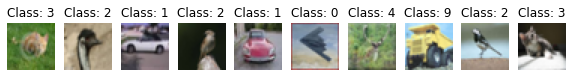

In [ ]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
''' 6. Multi Layer Perceptron (MLP) 모델 설계하기 '''
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.fc1=nn.Linear(32*32*3,512) #size 확인
    self.fc2=nn.Linear(512,256)
    self.fc3=nn.Linear(256,10)
    self.dropout_prob=0.5
    self.batch_norm1=nn.BatchNorm1d(512)
    self.batch_norm2=nn.BatchNorm1d(256)

  def forward(self,x):
    x=x.view(-1,32*32*3) 
    x=self.fc1(x)
    x=self.batch_norm1(x)
    x=F.relu(x)
    x=F.dropout(x,training=self.training,p=self.dropout_prob)
    x=self.fc2(x)
    x=self.batch_norm2(x)
    x=F.relu(x)
    x=F.dropout(x,training=self.training,p=self.dropout_prob)
    x=self.fc3(x)
    x=F.log_softmax(x,dim=1)
    return x

In [ ]:
''' 7. Optimizer, Objective Function 설정하기 '''
import torch.nn.init as init
def weight_init(m):
  if isinstance(m,nn.Linear):
    init.kaiming_uniform_(m.weight.data)

model=Net().to(DEVICE)
model.apply(weight_init)
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
criterion=nn.CrossEntropyLoss()

print(model)


Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader,optimizer,log_interval):
  model.train()
  for batch_idx, (image,label) in enumerate(train_loader):
    image=image.to(DEVICE)
    label=label.to(DEVICE)
    optimizer.zero_grad()
    output=model(image)
    loss=criterion(output,label)
    loss.backward()
    optimizer.step()

    if batch_idx %log_interval==0:
        print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
              epoch, batch_idx * len(image), 
              len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
              loss.item()))





In [ ]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [ ]:
''' 10. MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))





Train Epoch: 1 [0/50000 (0%)]	Train Loss: 3.002809
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.018296
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.925811
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.966333
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.787696
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.793262
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.000914
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.847446

[EPOCH: 1], 	Test Loss: 1.6281, 	Test Accuracy: 43.01 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.549308
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.894398
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.726771
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.903428
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.660470
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.843262
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.727377
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.829270

[EPOCH: 2], 	Test Loss: 1.5877, 	Test Accuracy: 42.46 % 